In [34]:
from __future__ import print_function
from __future__ import absolute_import

import sys
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import Dense, Dropout, Reshape, Permute
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.layers.recurrent import GRU
from keras.utils.data_utils import get_file
from keras.utils.layer_utils import convert_all_kernels_in_model

sys.path.insert(0, './deep-learning-models')
from audio_conv_utils import decode_predictions, preprocess_input

TH_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.3/music_tagger_crnn_weights_tf_kernels_th_dim_ordering.h5'
TF_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.3/music_tagger_crnn_weights_tf_kernels_tf_dim_ordering.h5'

K._LEARNING_PHASE = tf.constant(0)
K.LEARNING_PHASE = tf.constant(0)
K.set_learning_phase(0)

In [35]:
from __future__ import print_function

import os
import sys
import random
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, merge
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers.core import Masking
from keras.layers.recurrent import LSTM
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, CSVLogger
from keras.optimizers import rmsprop
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model

sys.path.insert(0, './deep-learning-models')
from music_tagger_crnn import MusicTaggerCRNN
from audio_conv_utils import preprocess_input, decode_predictions

from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import pylab as P

import socket
if socket.gethostname()=="euler":
    os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [36]:
def create_run_name(params):
    k_v_names = []
    for k,v in params.items():
        k_v_names.append((k,v))
        
    k_v_names.sort(key=lambda x: x[0])
    out_str = ""
    for k,v in k_v_names:
        out_str += k + "_" + str(v).replace('.', '-') + "|"
    return out_str[:-1]

In [37]:
test = False
params = {}
params['glob_margin'] = 1.0
params['num_hidden'] = 128
params['w_reg'] = 0.001
params['u_reg'] = 0.001
params['return_sequences'] = False

run_name = create_run_name(params)
run_name

'glob_margin_1-0|num_hidden_128|return_sequences_False|u_reg_0-001|w_reg_0-001'

In [38]:
# load all necessary files
valids = pickle.load(open("valids.pkl", "rb"))
pairs = pickle.load(open("pairs.pkl", "rb"))
msd_to_info = pickle.load(open("msd_to_info.pkl", "rb"))

In [39]:
print("valids size:", sys.getsizeof(valids)/1000000, "mB")
print("pairs size:", sys.getsizeof(pairs)/1000000, "mB")
print("msd_to_info size:", sys.getsizeof(msd_to_info)/1000000, "mB")

valids size: 2.097376 mB
pairs size: 2.853112 mB
msd_to_info size: 1.57296 mB


[ 0.445961    0.688843    0.99463728 ...,  0.9737456   0.9810458   0.9816389 ]


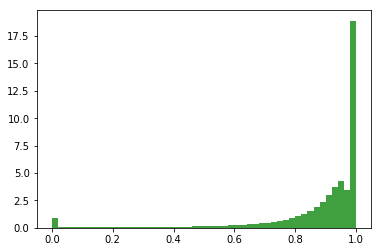

In [40]:
# most of the similarities lie close to zero
sims = np.asarray([float(x[2]) for x in pairs])
print(sims)
#n, bins, patches = plt.hist(sims, 50, normed=1, facecolor='green', alpha=0.75)
n, bins, patches = P.hist(sims, 50, normed=1, histtype='stepfilled')
P.setp(patches, 'facecolor', 'g', 'alpha', 0.75)

P.show()

In [41]:
zeros = 0
ones = 0
for x in sims:
    if x < 1e-2:
        zeros += 1
    elif x > 1 - 1e-2:
        ones += 1
print("zeros:", zeros)
print("ones:", ones)

zeros: 5648
ones: 114098


In [42]:
msd_to_info['TRNUDQL128E0783E5C']

('SHSDataset/mp3/3344 - Bali_Ha_i/18044.clip.mp3',
 "Bali Ha'i",
 'SODXUGX12A6310DBED',
 'On The Moon',
 'ARITVH41187B9A5FE4',
 'e670db87-f910-4286-bfc6-d7ddd0b0bfbd',
 'Peter Cincotti',
 239.25506,
 0.750112125537,
 0.433159162811,
 2004,
 18044,
 59758,
 28094,
 (('easy listening', 50.0), ('00s', 25.0), ('jazz', 100.0)))

In [43]:
# test the music tagger model for sanity
if test == True:
    model = MusicTaggerCRNN(weights='msd')

    shuffled_valids = list(valids)
    random.shuffle(shuffled_valids)

    count = 0
    for song in shuffled_valids:    
        audio_path = '/mnt/kahuna/MSD_audio/' + msd_to_info[song][0]
        tags = msd_to_info[song][-1]
        if type(tags) == type(0) or len(tags) == 0:
            # no tags
            tags = None
            continue
        melgram = preprocess_input(audio_path)
        melgrams = np.expand_dims(melgram, axis=0)

        preds = model.predict(melgrams)
        print(msd_to_info[song][1], msd_to_info[song][3], msd_to_info[song][6])
        print('Predicted:')
        print(decode_predictions(preds))
        print('Actual:')
        if tags is not None:
            print(sorted(list(tags),key=lambda x: x[1],reverse=True))
        else:
            print("N/A")
        print('-'*20)
        count += 1
        if count >= 20:
            break

In [44]:
pairs = np.asarray(pairs)
indices = np.arange(pairs.shape[0], dtype="int32")
np.random.shuffle(indices)
pairs = pairs[indices]
split_pt = int(len(pairs)/7)
pairs_train = pairs[:split_pt]
pairs_test = pairs[split_pt:]

In [45]:
# some useful functions:
def euc_dist(x):
    'Merge function: euclidean_distance(u,v)'
    print(x[0].get_shape(), x[1].get_shape())
    diff = tf.subtract(x[0], x[1])
    diff_sq = tf.square(diff)
    #output = tf.reduce_sum(diff_sq, 2)
    output_sq = tf.reduce_sum(diff_sq, 1)
    output = tf.sqrt(output_sq)
    output = tf.reshape(output, (-1,1))
    print("output.get_shape()", output.get_shape())
    return output

def euc_dist_shape(input_shape):
    'Merge output shape'
    shape = list(input_shape)
    #outshape = (shape[0][0],shape[0][1])
    outshape = (shape[0][0],1)
    print("outshape", outshape)
    return tuple(outshape)

def euc(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    dist = y_pred
    return K.mean(y_true * K.square(dist) + (1 - y_true) * K.square(K.maximum(params['glob_margin'] - dist, 0)))

def siamese_accuracy(y_true, y_pred):
    margin = tf.constant([params['glob_margin']])
    zero = tf.constant([0.0])
    return K.mean(K.equal(np.abs(1 - y_true), K.cast(K.greater_equal(y_pred, margin), 'float32')))

# add callback for learning rate
def step_decay(epoch):
    initial_lrate = 1e-6
    drop = 0.1
    epochs_drop = 150.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)

csv_logger = CSVLogger(run_name + '.log')
checkpointer = ModelCheckpoint(filepath='./' + run_name + '.hdf5', verbose=1, save_best_only=True)
optimizer = rmsprop(lr=0.0)

In [65]:
# now build actual model

# Determine proper input shape
if K.image_dim_ordering() == 'th':
    input_shape = (1, 96, 1366)
else:
    input_shape = (96, 1366, 1)

melgram_input1 = Input(shape=input_shape)
melgram_input2 = Input(shape=input_shape)

# Determine input axis
if K.image_dim_ordering() == 'th':
    channel_axis = 1
    freq_axis = 2
    time_axis = 3
else:
    channel_axis = 3
    freq_axis = 1
    time_axis = 2

layers = []
# Input block
layers.append(ZeroPadding2D(padding=(0, 37)))
layers.append(BatchNormalization(axis=time_axis, name='bn_0_freq'))

# Conv block 1
layers.append(Convolution2D(64, 3, 3, border_mode='same', name='conv1')) 
layers.append(BatchNormalization(axis=channel_axis, mode=0, name='bn1')) 
layers.append(ELU()) 
layers.append(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1')) 

# Conv block 2
layers.append(Convolution2D(128, 3, 3, border_mode='same', name='conv2')) 
layers.append(BatchNormalization(axis=channel_axis, mode=0, name='bn2')) 
layers.append(ELU()) 
layers.append(MaxPooling2D(pool_size=(3, 3), strides=(3, 3), name='pool2')) 

# Conv block 3
layers.append(Convolution2D(128, 3, 3, border_mode='same', name='conv3')) 
layers.append(BatchNormalization(axis=channel_axis, mode=0, name='bn3')) 
layers.append(ELU()) 
layers.append(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), name='pool3')) 

# Conv block 4
layers.append(Convolution2D(128, 3, 3, border_mode='same', name='conv4'))
layers.append(BatchNormalization(axis=channel_axis, mode=0, name='bn4'))
layers.append(ELU())
layers.append(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), name='pool4'))

# reshaping
layers.append(Reshape((15, 128)))

# GRU block 1, 2, output
layers.append(GRU(32, return_sequences=True, name='gru1'))
layers.append(GRU(32, return_sequences=False, name='gru2'))

x1 = layers[0](melgram_input1)
x2 = layers[0](melgram_input2)

for l in layers[1:]:
    x1 = l(x1)
    x2 = l(x2)

output = merge([x1, x2], mode=euc, output_shape=euc_dist_shape)

model = Model(input=[melgram_input1, melgram_input2], output=[output])

# Load weights
if K.image_dim_ordering() == 'tf':
    weights_path = get_file('music_tagger_crnn_weights_tf_kernels_tf_dim_ordering.h5',
                            TF_WEIGHTS_PATH,
                            cache_subdir='models')
else:
    weights_path = get_file('music_tagger_crnn_weights_tf_kernels_th_dim_ordering.h5',
                            TH_WEIGHTS_PATH,
                            cache_subdir='models')
model.load_weights(weights_path, by_name=True)
if K.backend() == 'theano':
    convert_all_kernels_in_model(model)

model.compile(optimizer=optimizer, loss=contrastive_loss, metrics=['mean_squared_error'])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", name="conv1")`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(axis=3, name="bn1")`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", name="conv2")`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(axis=3, name="bn2")`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", name="conv3")`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:41: UserWarning: Update your `BatchNormalization` call to 

outshape (None, 1)


In [66]:
crnn_out1_f = K.function(model.inputs, [x1])
crnn_out2_f = K.function(model.inputs, [x2])
crnn1_grad_f = K.function(model.inputs, [K.gradients(x1, model.inputs)[0]])
crnn2_grad_f = K.function(model.inputs, [K.gradients(x2, model.inputs)[1]])
end_grad_f = K.function([x1,x2], K.gradients(output, [x1,x2]))

In [60]:
model.layers

In [61]:
def librosa_exists():
    try:
        __import__('librosa')
    except ImportError:
        return False
    else:
        return True
    
def preprocess_input(audio_path, dim_ordering='default'):
    '''Reads an audio file and outputs a Mel-spectrogram.
    '''
    if dim_ordering == 'default':
        dim_ordering = K.image_dim_ordering()
    assert dim_ordering in {'tf', 'th'}

    if librosa_exists():
        import librosa
    else:
        raise RuntimeError('Librosa is required to process audio files.\n' +
                           'Install it via `pip install librosa` \nor visit ' +
                           'http://librosa.github.io/librosa/ for details.')

    # mel-spectrogram parameters
    SR = 12000
    N_FFT = 512
    N_MELS = 96
    HOP_LEN = 256
    DURA = 29.12
    
    try:
        src, sr = librosa.load(audio_path, sr=SR)
    except:
        print("Unexpected error5:", sys.exc_info()[0])
        raise
    n_sample = src.shape[0]
    n_sample_wanted = int(DURA * SR)

    # trim the signal at the center
    if n_sample < n_sample_wanted:  # if too short
        src = np.hstack((src, np.zeros((int(DURA * SR) - n_sample,))))
    elif n_sample > n_sample_wanted:  # if too long
        src = src[int((n_sample - n_sample_wanted) / 2):
                  int((n_sample + n_sample_wanted) / 2)]

    logam = librosa.logamplitude
    melgram = librosa.feature.melspectrogram
    x = logam(melgram(y=src, sr=SR, hop_length=HOP_LEN,
                      n_fft=N_FFT, n_mels=N_MELS) ** 2,
              ref_power=1.0)

    if dim_ordering == 'th':
        x = np.expand_dims(x, axis=0)
    elif dim_ordering == 'tf':
        x = np.expand_dims(x, axis=3)
    return x

In [63]:
def generate_samples(pairs, minibatch_size):
    i = 0
    n = len(pairs)
    while 1:
        x_1_arr = np.empty((minibatch_size, 96, 1366, 1))
        x_2_arr = np.empty((minibatch_size, 96, 1366, 1))
        y_arr = np.empty((minibatch_size,))
        while i < minibatch_size:
            rand_num = random.randint(0,n-1)
            print(rand_num)
            x_1, x_2, y = pairs[random.randint(0,n-1)]
            audio_path1 = '/mnt/kahuna/MSD_audio/' + msd_to_info[x_1][0]
            audio_path2 = '/mnt/kahuna/MSD_audio/' + msd_to_info[x_2][0]
            try:
                melgram1 = preprocess_input(audio_path1)
                melgram2 = preprocess_input(audio_path2)
            except:
                print("Unexpected error4:", sys.exc_info()[0])
                #print(audio_path1, audio_path2)
                #continue
                raise
            if np.sum(np.isnan(melgram1)) > 0 or np.sum(np.isnan(melgram2)) > 0:
                print("nan!")
                continue
            if np.sum(melgram1) > 0 or np.sum(melgram2) > 0:
                print("zero!")
                continue
            x_1_arr[i,:,:,:] = np.expand_dims(melgram1, axis=0)
            x_2_arr[i,:,:,:] = np.expand_dims(melgram2, axis=0)
            y_arr[i] = y
            i += 1
        #print("generated the {}th sample".format(i))
        yield(([x_1_arr, x_2_arr], y_arr))

count = 0
tf_false = tf.cast(tf.constant([0.0]), 'bool')
for x, y in generate_samples(pairs_train, 4):
    x_1, x_2 = x
    #print(x_1,x_2)
    K.set_learning_phase(False)
    print(crnn_out1_f([x_1,x_2]))
    print(crnn_out2_f([x_1,x_2]))
    dist = model.predict([x_1, x_2])
    print(model.predict([x_1, x_2]))
    loss = contrastive_loss(y, dist)
    loss = K.eval(loss)
    print(loss)
    #print(lstm_out1_f([x_1,x_2]), lstm_out2_f([x_1,x_2]))
    count += 1
    if count > 0:
        break

27971
44223
4283
26298
[array([[-0.2385257 ,  0.35595119, -0.9633112 ,  0.60060775, -0.06446465,
         0.91847783, -0.12528034, -0.19729918, -0.28288305,  0.16121395,
        -0.70382422, -0.07910858, -0.108913  ,  0.08156931, -0.12979852,
        -0.23921441,  0.28929105, -0.96228033,  0.17992207,  0.12533551,
        -0.10632191,  0.13912532, -0.37276405, -0.28528273,  0.80315596,
         0.56534606,  0.76196551, -0.14129741, -0.95349604,  0.01233207,
         0.49419397, -0.05498601],
       [-0.02443022,  0.67395175, -0.9926244 ,  0.43474472, -0.42779216,
         0.95103037, -0.00831575,  0.01247025, -0.33928674,  0.61371303,
         0.29974806, -0.06223679, -0.10142215,  0.17808932, -0.2000782 ,
        -0.78416872,  0.13031653, -0.97587812,  0.05265776,  0.69811857,
         0.41318181,  0.64115125, -0.36848801, -0.79304981,  0.32055315,
         0.39677745,  0.36411735, -0.33418548, -0.97473711,  0.26291668,
        -0.21052638, -0.30567592],
       [-0.1996634 ,  0.525834

In [51]:
dir(model.layers[-3])

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_inbound_node',
 '_built',
 '_constraints',
 '_get_node_attribute_at_index',
 '_initial_weights',
 '_losses',
 '_non_trainable_weights',
 '_per_input_losses',
 '_per_input_updates',
 '_trainable_weights',
 '_updates',
 'activation',
 'activity_regularizer',
 'add_loss',
 'add_update',
 'add_weight',
 'assert_input_compatibility',
 'bias',
 'bias_constraint',
 'bias_h',
 'bias_initializer',
 'bias_r',
 'bias_regularizer',
 'bias_z',
 'build',
 'built',
 'call',
 'compute_mask',
 'compute_output_shape',
 'constraints',
 'count_params',
 'dropout',
 'from_config',
 'get_config',
 'get_constants',
 'get_initial_states',
 'get_inp

In [52]:
model.layers[-2].get_weights()

[array([[-0.03883676, -0.19665682,  0.09519399, ..., -0.01679893,
         -0.11232486, -0.05320075],
        [ 0.10318386,  0.00750141,  0.0877763 , ...,  0.28539926,
         -0.26765713,  0.12707934],
        [ 0.02139056, -0.20284753, -0.13729262, ...,  0.06997423,
         -0.18604344,  0.16012473],
        ..., 
        [-0.29321396,  0.13158584,  0.07120441, ..., -0.27863073,
          0.13259968, -0.3381097 ],
        [-0.29643059, -0.43796661, -0.38792628, ...,  0.24001566,
          0.53937805, -0.31751484],
        [-0.15014616,  0.38404396,  0.02415507, ...,  0.11745741,
         -0.77597785,  0.13635641]], dtype=float32),
 array([[ -9.47186053e-01,   1.60324425e-01,   1.57704294e-01, ...,
           8.05203021e-02,  -1.34790933e+00,   9.51107025e-01],
        [ -1.63089693e-01,  -6.83150172e-01,  -1.21464767e-01, ...,
           1.34107387e+00,   1.12605959e-01,  -1.98369956e+00],
        [ -2.48719994e-02,  -5.93665354e-02,   9.10036623e-01, ...,
          -9.65682745e-01

In [71]:
# TODO: print all the different learning phases
#print(type(x_1))
#print(model.inputs)
print(crnn_out1_f([x_2, x_2]))
#print(crnn_out2_f([x_1,x_2]))

[array([[ 0.70976204, -0.34295353, -0.61553907, -0.07976322,  0.46822467,
         0.24924265, -0.4485752 ,  0.22979632, -0.08877571, -0.5345602 ,
        -0.13477644, -0.10183962, -0.11997261, -0.91196299, -0.04045971,
         0.32885331,  0.34113938, -0.90098959,  0.18149097,  0.00174973,
        -0.57917404, -0.52865779, -0.22759591,  0.31538695, -0.3420206 ,
         0.31757373,  0.19841848, -0.16221382, -0.45655236,  0.02530195,
        -0.03206787,  0.05971357],
       [ 0.8808859 ,  0.4629702 , -0.25143445,  0.15781571,  0.35889751,
         0.6090796 ,  0.12989223,  0.17423958, -0.87150872,  0.10884797,
        -0.49157411, -0.08396518, -0.12635106, -0.83465147, -0.74659991,
         0.01236937,  0.97253269, -0.97352302, -0.45654759, -0.08109133,
        -0.16528143, -0.46046469, -0.21558517,  0.21374586, -0.45235693,
         0.1585604 , -0.01792768, -0.19036345, -0.00700196, -0.1932922 ,
         0.50091588, -0.0150629 ],
       [ 0.85154581,  0.95284379,  0.70895368,  0.213

In [54]:
import librosa
SR = 12000
for i, p in enumerate(pairs_train):
    x1, x2, y = p
    audio_path1 = '/mnt/kahuna/MSD_audio/' + msd_to_info[x1][0]
    audio_path2 = '/mnt/kahuna/MSD_audio/' + msd_to_info[x2][0]
    src1 = librosa.load(audio_path1, sr=SR)
    src2 = librosa.load(audio_path1, sr=SR)
    print(np.sum(src1), "|", np.sum(src2))
    if i >= 10:
        break

[ 12000.  12000.  12000. ...,  12000.  12000.  12000.] | [ 12000.  12000.  12000. ...,  12000.  12000.  12000.]
[ 12000.  12000.  12000. ...,  12000.  12000.  12000.] | [ 12000.  12000.  12000. ...,  12000.  12000.  12000.]
[ 12000.  12000.  12000. ...,  12000.  12000.  12000.] | [ 12000.  12000.  12000. ...,  12000.  12000.  12000.]
[ 12000.          12000.          12000.         ...,  11999.99804688
  12000.          12000.        ] | [ 12000.          12000.          12000.         ...,  11999.99804688
  12000.          12000.        ]
[ 12000.  12000.  12000. ...,  12000.  12000.  12000.] | [ 12000.  12000.  12000. ...,  12000.  12000.  12000.]
[ 12000.          12000.          12000.         ...,  12000.
  11999.99902344  12000.        ] | [ 12000.          12000.          12000.         ...,  12000.
  11999.99902344  12000.        ]
[ 12000.  12000.  12000. ...,  12000.  12000.  12000.] | [ 12000.  12000.  12000. ...,  12000.  12000.  12000.]
[ 12000.  12000.  12000. ...,  12000

In [ ]:
# debug nans
keep_looping = True
count = 0
for x, y in generate_samples(pairs_train, 1):
    prev_input = [x,y]
    prev_weights2 = model.layers[-2].get_weights()
    prev_weights3 = model.layers[-3].get_weights()
    model.fit(x, y, batch_size=1, epochs=1, verbose=0)
    #print("loop num:", count, x)
    for w in model.layers[-2].get_weights():
        if np.sum(np.isnan(w)) > 0:
            keep_looping = False
            break
    if keep_looping == False:
        break
    for w in model.layers[-3].get_weights():
        if np.sum(np.isnan(w)) > 0:
            keep_looping = False
            break
    if keep_looping == False:
        break
    count += 1

15577


In [ ]:
model.layers[-2].get_weights()

In [ ]:
model.layers[-3].get_weights()

In [ ]:
x, y = prev_input
print(np.argwhere(np.isnan(x[0])))
print(np.sum(np.isnan(x[0])))
print(np.sum(np.isnan(x[1])))

In [ ]:
len(np.argwhere(np.isnan(x[0])))

In [ ]:
print("test 1")
for elem in x:
    if np.sum(elem) > 0:
        print(np.sum(elem))

print("test 2")
for i in range(x[0].shape[0]):
    if np.sum(np.isclose(x[0][i,...], x[1][i,...])):
        print(i)

In [72]:
x, y = prev_input
model.layers[-2].set_weights(prev_weights2)
model.layers[-3].set_weights(prev_weights3)
dist = model.predict(x)
crnn_out1 = crnn_out1_f(x)
crnn_out2 = crnn_out2_f(x)
loss = contrastive_loss(y, dist)
grad1 = crnn1_grad_f(x)
grad2 = crnn2_grad_f(x)
end_grad = end_grad_f([crnn_out1[0], crnn_out2[0]])
print(crnn_out1[0].shape, crnn_out2[0].shape)
print(crnn_out1)
print(crnn_out2)
#print("-"*20)
#print(grad1[0].shape, grad2[0].shape)
#print(grad1)
#print(grad2)
print("-"*20)
print(end_grad[0].shape, end_grad[1].shape)
print(end_grad)
print(dist)
print(K.eval(loss))

(1, 32) (1, 32)
[array([[-0.20428671,  0.82197344,  0.19314764,  0.13846055, -0.10819153,
        -0.13599275,  0.12320132, -0.46429175,  0.90909827,  0.16137615,
        -0.53901476,  0.67054307,  0.83940256,  0.06412182, -0.80935675,
        -0.07365309,  0.00632952,  0.20396236,  0.89766496, -0.65150899,
         0.23808403,  0.21640357,  0.71191549,  0.10054032, -0.27683973,
         0.01034541,  0.02621806,  0.61473495,  0.25212139,  0.77928054,
        -0.07494275, -0.79768127]], dtype=float32)]
[array([[-0.0764785 , -0.07561693,  0.11879298,  0.38892731,  0.08373836,
        -0.22229081,  0.12435176, -0.48225555,  0.08445067,  0.18288572,
        -0.01890013,  0.29773507,  0.64701045,  0.07625987, -0.0432539 ,
         0.33944228, -0.051684  , -0.22899328, -0.43555868, -0.06058469,
        -0.63240761,  0.1276195 ,  0.15327746, -0.21170387,  0.25108832,
        -0.3210032 ,  0.02800143,  0.44193915,  0.2638199 ,  0.26973233,
        -0.07944777,  0.04555594]], dtype=float32)]
--

In [ ]:
end_grad[0].shape

In [ ]:
model.fit(x, y)

In [ ]:
print_every = 1 # print every n minibatches
minibatch_size = 8
number_of_batches = 100
hist = model.fit_generator(generate_samples(pairs_train, minibatch_size), steps_per_epoch=print_every, epochs=number_of_batches,
                   #validation_data=generate_samples(pairs_test, minibatch_size), validation_steps=1,
                   callbacks=[lrate, csv_logger, checkpointer], verbose=1)

In [ ]:
X_t = K.placeholder(ndim=2) #specify the right placeholder
Y_t = K.sum(K.square(X_t)) # loss function
fn = K.function([X_t], K.gradients(Y_t, [X_t])) #function to call the gradient

In [ ]:
x_t = np.asarray([[1,2],[3,4]])
fn([x_t])